# Bonus Assignment

Refrence Links:

[Variational AutoEncoders (G4G)](https://www.geeksforgeeks.org/variational-autoencoders/)

[Understanding VAEs](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

### Group Members:


*   Ali Zahedzadeh
*   Melika Noubakhtian

### What is a Variational Autoencoder?

Variational Autoencoders (VAEs) are a class of generative models that blend the principles of autoencoders with probabilistic latent variable models. Unlike traditional autoencoders, which learn a deterministic mapping from input data to a fixed-size representation, VAEs introduce a probabilistic approach to encoding. This innovation makes them particularly adept at capturing and generating complex, high-dimensional data distributions.

The fundamental idea behind a VAE is to view the encoding process as a sampling operation from a latent space with a specified probabilistic structure. This enables the model to not only reconstruct input data but also generate new samples by drawing from the learned latent space distribution. VAEs have found applications in various domains, including image generation, data compression, and representation learning.

### Architecture of Variational Autoencoder

#### **Encoder**:
The encoder component of a VAE maps input data to a probability distribution in the latent space. Rather than outputting a deterministic code, the encoder produces the parameters (mean and variance) of a multivariate normal distribution. This introduces a stochastic element, allowing for the generation of diverse samples during training and inference.

#### **Latent Space and Sampler**:
The latent space in a VAE is the heart of its generative power. It is a continuous, high-dimensional space where each point represents a possible encoding of input data. The latent space is typically assumed to follow a standard normal distribution, which facilitates sampling during the generation process.

#### **Decoder**:
The decoder takes a sample from the latent space and reconstructs it back to the original input space. This reconstruction process involves generating a probability distribution over the output space, often modeled as a Bernoulli distribution for binary data or a Gaussian distribution for continuous data. The decoder is trained to generate outputs that match the input data distribution.

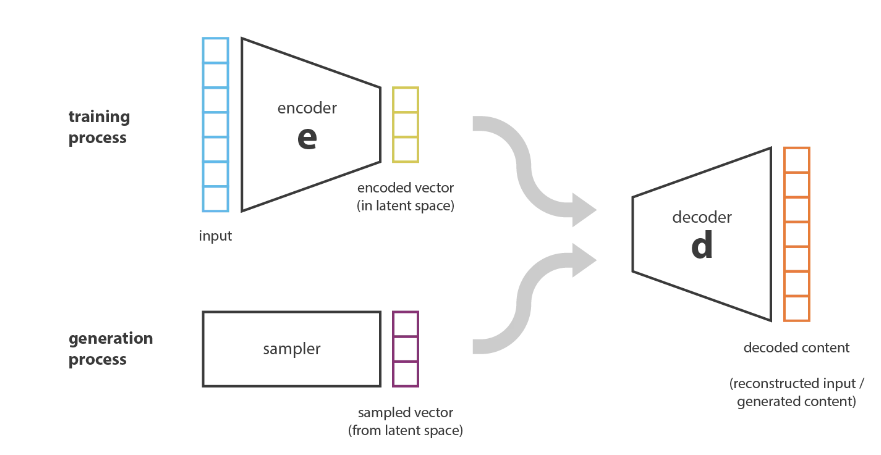



### Mathematics behind Variational Autoencoder

#### Objective Function:
The training of a VAE involves maximizing a lower bound on the log-likelihood of the data. This lower bound is expressed as the sum of the reconstruction term and the regularization term.

$ \mathcal{L}(\theta, \phi; x) = -\mathbb{E}_{q_\phi(z | x)}[\log p_\theta(x | z)] + \text{KL}(q_\phi(z | x) || p(z)) $

Here, $\theta$ and $\phi$ denote the parameters of the decoder and encoder, respectively. The first term encourages accurate reconstruction, and the second term, the Kullback-Leibler (KL) divergence, enforces the encoded distribution to approximate a standard normal distribution.

#### Reparameterization Trick:
To enable backpropagation through the stochastic sampling process during training, the reparameterization trick is employed. It involves expressing the sampling operation as a deterministic transformation of a noise variable and the parameters of the distribution.

$z = \mu + \sigma \odot \epsilon $

Here, $ \mu $ and $\sigma $ are the mean and standard deviation parameters predicted by the encoder, and $\epsilon $ is a noise variable sampled from a standard normal distribution.

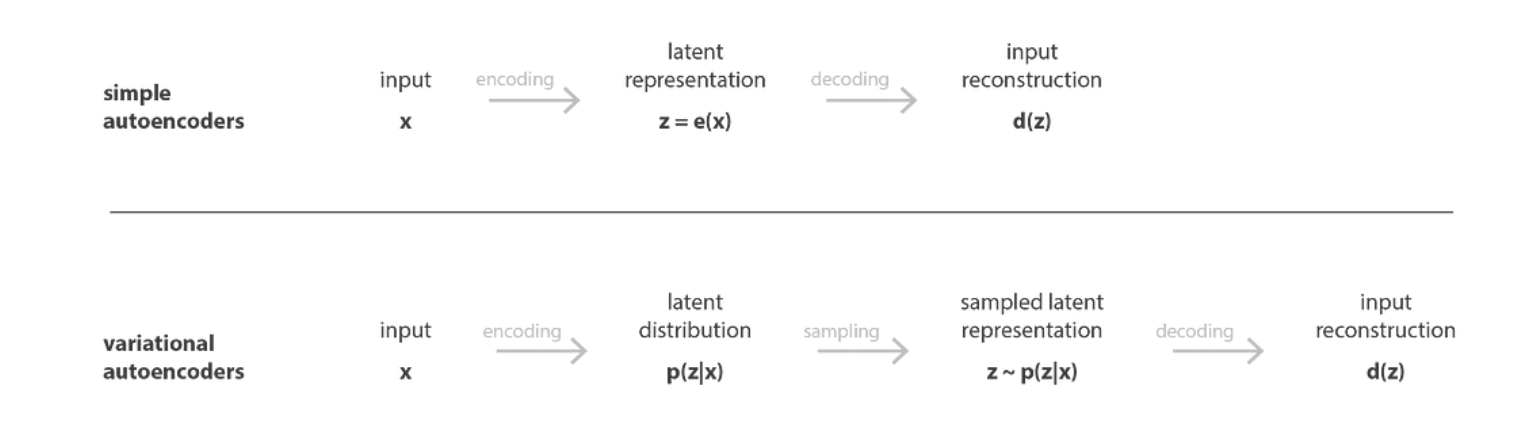

Now we are familiar with VAE structure and we can implement it!

**Import Libraries**

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

## Sampling Layer

The sampling process that we mentioned earlier needs an special layer that is not available directly from Keras layer. Due to this, we design this layer manually. This layer takes mean and variance from encoder and converts them to normal distribution to sample from them:

In [2]:
# Reparameterization trick
class Sampling(layers.Layer):
    """Input: (mean, log_var) to sample z, the vector encoding a digit.
       output: normal distribition with defined mean and var"""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

## Encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 6272)                 0         ['conv2d_1[0][0]']            
                                                                                            

## Decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       73856     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         577 

## VAE

Earlier in this notebook, we mentioned KL-divergence but we just talked about it in summary. Becuase it's a crucial part of our VAE loss, we explain more about this here:

<hr>

Kullback-Leibler (KL) divergence, often denoted as $ \text{KL}(P || Q) $, is a measure of how one probability distribution, $ P $, diverges from a second probability distribution, $ Q $.

The KL divergence between two probability distributions $ P(z) $ and $Q(z) $ is defined as follows:

$ \text{KL}(P || Q) = \int P(z) \log \frac{P(z)}{Q(z)} \, dz $

We know that the KL-divergence is a regularization term in the loss objective function. The specific form of the KL divergence term for a VAE is:

$\text{KL}(q_\phi(z | x) || p(z)) = \frac{1}{2} \sum_{i=1}^{N} \left( \sigma_i^2 + \mu_i^2 - 1 - \log(\sigma_i^2) \right)$


Here, $q_\phi(z | x) $ is the distribution of the latent variable $ z $ given the input $ x $ as predicted by the encoder. $ p(z) $ is the desired prior distribution, typically assumed to be a standard normal distribution. $ \mu_i $ and $ \sigma_i $ are the mean and standard deviation of the distribution $ q_\phi(z | x) $.

The KL divergence term penalizes the encoder for deviating from the desired prior distribution. Minimizing the KL divergence encourages the VAE to learn a structured and continuous latent space that facilitates smooth generation during sampling.

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        """ VAE loss consisted of two part:
                - Reconstruction loss
                - KL divergence
            And our total loss will be:
                total loss = Reconstruction Loss + KL divergence
        """

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean,log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            # KL loss
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # total loss
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Now we can train VAE on fashion MNIST:

In [7]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 12s 14ms/step - loss: 292.6457 - reconstruction_loss: 287.6841 - kl_loss: 4.6116
Epoch 2/20
547/547 [==============================] - 8s 14ms/step - loss: 290.7330 - reconstruction_loss: 286.2408 - kl_loss: 4.5935
Epoch 3/20
547/547 [==============================] - 8s 14ms/step - loss: 290.4743 - reconstruction_loss: 285.5415 - kl_loss: 4.5808
Epoch 4/20
547/547 [==============================] - 8s 14ms/step - loss: 289.0879 - reconstruction_loss: 285.1973 - kl_loss: 4.5600
Epoch 5/20
547/547 [==============================] - 8s 14ms/step - loss: 288.9370 - reconstruction_loss: 284.5159 - kl_loss: 4.5501
Epoch 6/20
547/547 [==============================] - 7s 14ms/step - loss: 288.0231 - reconstruction_loss: 283.9043 - kl_loss: 4.5394
Epoch 7/20
547/547 [==============================] - 8s 14ms/step - loss: 287.9232 - reconstruction_loss: 283.4369 - kl_loss: 4.5170
Epoch 8/20
547/547 [==============================] - 8s 14ms

After training, now we can visualize the latent space of VAE. The following function generates a 2D manifold of images by sampling points in the latent space and decoding them back into the input space.

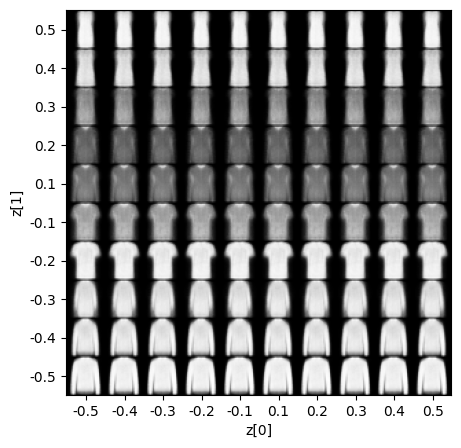

In [8]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
    # display 2D manifold of images
    img_size = 28
    scale = 0.5
    figure = np.zeros((img_size * n, img_size * n))

    # linearly spaced coordinates corresponding to the 2D plot
    # of images classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    # Now we give these latent points to the decoder model to generate images
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(sample, verbose=0)
            images = x_decoded[0].reshape(img_size, img_size)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = images

    # Now we visualize generated images with their sampled values
    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)